### Predicting the Movement of Sliver Stock Price

In [1]:
import pandas as pd
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Silver_HistoricalData_1669917710205.csv')

In [3]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/30/2022,21.781,62564.0,21.415,22.410,21.355
1,11/29/2022,21.436,45726.0,21.130,21.635,21.060
2,11/28/2022,21.125,57501.0,21.640,21.815,21.045
3,11/25/2022,21.609,30139.0,21.785,21.880,21.355
4,11/23/2022,21.526,20315.0,21.260,21.780,21.095


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1259 non-null   object 
 1   Close/Last  1259 non-null   float64
 2   Volume      1250 non-null   float64
 3   Open        1259 non-null   float64
 4   High        1259 non-null   float64
 5   Low         1259 non-null   float64
dtypes: float64(5), object(1)
memory usage: 59.1+ KB


In [5]:
df.describe()

,Close/Last,Volume,Open,High,Low
count,1259.000000,1250.00000,1259.000000,1259.000000,1259.000000
mean,19.806008,62633.14320,19.820060,20.047642,19.558702
std,4.329010,37798.69542,4.339982,4.426561,4.227206
min,11.772000,1.00000,11.975000,12.330000,11.640000
25%,16.133000,42252.75000,16.140000,16.257500,15.992500
50%,18.168000,60558.50000,18.160000,18.400000,17.975000
75%,23.998000,77649.75000,24.020000,24.305000,23.617500
max,29.418000,347002.00000,29.235000,30.350000,28.300000


In [60]:
df['Date'] = pd.to_datetime(df['Date'])

In [61]:
df['Date']

0      2022-11-30
1      2022-11-29
2      2022-11-28
3      2022-11-25
4      2022-11-23
          ...    
1254   2017-12-07
1255   2017-12-06
1256   2017-12-05
1257   2017-12-04
1258   2017-12-01
Name: Date, Length: 1259, dtype: datetime64[ns]

#### Lets plot the stock data

Text(0.5, 1.0, 'Price per day from 01-12-2017 for Silver in $')

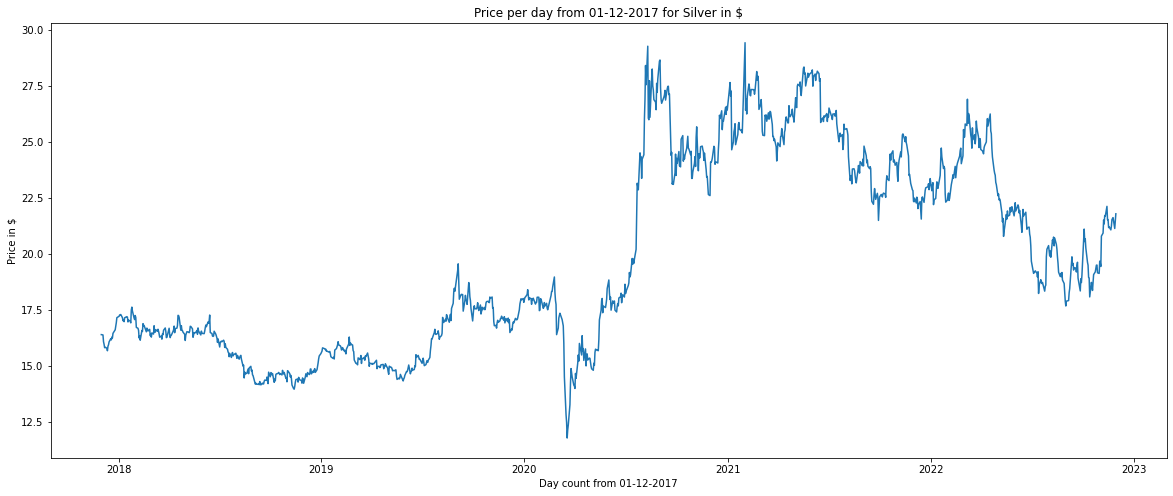

In [65]:
plt.figure(figsize=(20,8))
#plt.plot(df['Close/Last'])
plt.plot(df['Date'],df['Close/Last'])
plt.ylabel('Price in $')
plt.xlabel('Day count from 01-12-2017')
plt.title('Price per day from 01-12-2017 for Silver in $')

#### Scaling the data as LSTM's are sensitive to numeric values, this is a good paractice to normalise values before applying any ML algorithm

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
df_1 = df['Close/Last']

In [9]:
df_1.head()

0    21.781
1    21.436
2    21.125
3    21.609
4    21.526
Name: Close/Last, dtype: float64

In [10]:
df_1

0       21.781
1       21.436
2       21.125
3       21.609
4       21.526
         ...  
1254    15.802
1255    15.955
1256    16.068
1257    16.373
1258    16.388
Name: Close/Last, Length: 1259, dtype: float64

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
df_1 = scaler.fit_transform(np.array(df_1).reshape(-1,1))

In [12]:
df_1

array([[0.5672107 ],
       [0.54765953],
       [0.53003514],
       ...,
       [0.24345461],
       [0.26073898],
       [0.26158903]])

In [13]:
df_1.shape

(1259, 1)

#### Now Since we are working on time series data its always we have to split sequentially for Training and Testing

In [14]:
#Lets set the train size and test size and do the split
train_size=int(len(df_1)*0.80)  #Split is 70% train and 30% test
test_size=len(df_1)-train_size

In [15]:
train_data, test_data=df_1[0:train_size,:], df_1[train_size:len(df_1),:1]

In [16]:
train_size, train_data, test_size, test_data

(1007,
 array([[0.5672107 ],
        [0.54765953],
        [0.53003514],
        ...,
        [0.15924289],
        [0.16252975],
        [0.15453927]]),
 252,
 array([[0.13855831],
        [0.14904228],
        [0.15204579],
        [0.13878499],
        [0.14569874],
        [0.14705882],
        [0.15346254],
        [0.14150516],
        [0.14909895],
        [0.14790887],
        [0.14116514],
        [0.13079451],
        [0.12354075],
        [0.12478749],
        [0.13419472],
        [0.15023235],
        [0.15850618],
        [0.15459594],
        [0.16292644],
        [0.16910348],
        [0.17029355],
        [0.14224187],
        [0.15244248],
        [0.15130908],
        [0.16592996],
        [0.16196305],
        [0.16456987],
        [0.17120027],
        [0.15952624],
        [0.16309645],
        [0.16048963],
        [0.16383316],
        [0.16598663],
        [0.16343647],
        [0.1622464 ],
        [0.16060297],
        [0.14473535],
        [0.14892894],
    

#### Convert to the dataset matrix

In [17]:
def create_dataset(dataset, time_step=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  #i=0,1,2,3,4,5
        data_X.append(a)
        data_Y.append(dataset[i+time_step, 0])
    return np.array(data_X), np.array(data_Y)

In [18]:
# Reshape into X=t, t+1, t+2 and Y=t+4
time_step = 10
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train)

[[0.5672107  0.54765953 0.53003514 ... 0.53405871 0.53224527 0.55264649]
 [0.54765953 0.53003514 0.55746345 ... 0.53224527 0.55264649 0.55230647]
 [0.53003514 0.55746345 0.55275983 ... 0.55264649 0.55230647 0.58602516]
 ...
 [0.1755072  0.17261702 0.16598663 ... 0.16184971 0.1605463  0.16570328]
 [0.17261702 0.16598663 0.16927349 ... 0.1605463  0.16570328 0.15510597]
 [0.16598663 0.16927349 0.16235974 ... 0.16570328 0.15510597 0.15924289]]


In [20]:
print(Y_train)

[0.55230647 0.58602516 0.56075031 0.56273376 0.54148249 0.55139975
 0.5183611  0.51071064 0.43397937 0.44327326 0.44741018 0.41635498
 0.41794174 0.43760626 0.4371529  0.4293891  0.42032189 0.41335147
 0.39198685 0.37328573 0.38694322 0.39368695 0.35696475 0.4049643
 0.4060977  0.43720957 0.44446333 0.48073218 0.50368355 0.49710983
 0.52856171 0.49965998 0.41182138 0.39329026 0.40281084 0.37203899
 0.38014281 0.40451094 0.44457667 0.43681288 0.41998187 0.42989913
 0.43120254 0.42485549 0.44185651 0.43743625 0.4583475  0.39640712
 0.37798935 0.36767539 0.34772753 0.34619744 0.33401337 0.34625411
 0.36920549 0.39091012 0.39969398 0.41873512 0.40813782 0.41646832
 0.40847784 0.41958518 0.44185651 0.45749745 0.477842   0.48962938
 0.50583702 0.48605916 0.5083305  0.49359628 0.50107673 0.45732744
 0.47319506 0.46027428 0.47415845 0.48679587 0.47744531 0.45880086
 0.38694322 0.38325966 0.37152896 0.38790661 0.39368695 0.39079678
 0.39334693 0.40054403 0.3866032  0.36569194 0.42060524 0.40723

In [21]:
len(X_train), len(Y_train)

(996, 996)

In [22]:
len(X_test), len(Y_test)

(241, 241)

In [23]:
X_train.shape, Y_train.shape

((996, 10), (996,))

#### Now we need to reshape the inputs to a 3D array of [samples, time samples, features] for the LSTM Neural Network 

In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
print(X_train), print(X_test)

[[[0.5672107 ]
  [0.54765953]
  [0.53003514]
  ...
  [0.53405871]
  [0.53224527]
  [0.55264649]]

 [[0.54765953]
  [0.53003514]
  [0.55746345]
  ...
  [0.53224527]
  [0.55264649]
  [0.55230647]]

 [[0.53003514]
  [0.55746345]
  [0.55275983]
  ...
  [0.55264649]
  [0.55230647]
  [0.58602516]]

 ...

 [[0.1755072 ]
  [0.17261702]
  [0.16598663]
  ...
  [0.16184971]
  [0.1605463 ]
  [0.16570328]]

 [[0.17261702]
  [0.16598663]
  [0.16927349]
  ...
  [0.1605463 ]
  [0.16570328]
  [0.15510597]]

 [[0.16598663]
  [0.16927349]
  [0.16235974]
  ...
  [0.16570328]
  [0.15510597]
  [0.15924289]]]
[[[0.13855831]
  [0.14904228]
  [0.15204579]
  ...
  [0.14150516]
  [0.14909895]
  [0.14790887]]

 [[0.14904228]
  [0.15204579]
  [0.13878499]
  ...
  [0.14909895]
  [0.14790887]
  [0.14116514]]

 [[0.15204579]
  [0.13878499]
  [0.14569874]
  ...
  [0.14790887]
  [0.14116514]
  [0.13079451]]

 ...

 [[0.25518531]
  [0.24827156]
  [0.25121841]
  ...
  [0.22741698]
  [0.22957044]
  [0.22838037]]

 [[0.248

(None, None)

In [26]:
print(len(X_train)), print(len(X_test))

996
241


(None, None)

In [27]:
print(X_train.shape, X_test.shape)

(996, 10, 1) (241, 10, 1)


#### Create the LSTM Neural Network model using Tensorflow

In [28]:
import tensorflow

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [30]:
#Building a stacked LSTM model

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10,1))) #Input Layer with 10 time steps
model.add(LSTM(50, return_sequences=True)) #Layer 2
model.add(LSTM(50)) #Layer 3 pre output with no return sequences
model.add(Dense(1)) #Output Layer
model.compile(loss="mean_squared_error", optimizer='adam')

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=120, batch_size=64, verbose=1)

Epoch 1/120
16/16 [==============================] - 4s 100ms/step - loss: 0.1309 - val_loss: 0.0487
Epoch 2/120
16/16 [==============================] - 0s 14ms/step - loss: 0.0172 - val_loss: 0.0147
Epoch 3/120
16/16 [==============================] - 0s 11ms/step - loss: 0.0087 - val_loss: 0.0033
Epoch 4/120
16/16 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 4.2025e-04
Epoch 5/120
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 3.8618e-04
Epoch 6/120
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 3.7557e-04
Epoch 7/120
16/16 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 3.8658e-04
Epoch 8/120
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 3.6920e-04
Epoch 9/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 4.0571e-04
Epoch 10/120
16/16 [==============================] - 0s 10ms/step - loss: 0

16/16 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 2.2416e-04
Epoch 80/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 3.0704e-04
Epoch 81/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 2.2194e-04
Epoch 82/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 2.0034e-04
Epoch 83/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 1.9817e-04
Epoch 84/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 2.1417e-04
Epoch 85/120
16/16 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 1.9456e-04
Epoch 86/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 2.2957e-04
Epoch 87/120
16/16 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 2.0918e-04
Epoch 88/120
16/16 [==============================] - 0s 10ms/step - loss: 

In [48]:
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)

#### Now we need to transform back the predictions to their original values which are human interepretable

In [49]:
X_train_predictions_transformed = scaler.inverse_transform(X_train_predictions)
X_test_predictions_transformed = scaler.inverse_transform(X_test_predictions)

#### Calculating the metrics

In [50]:
import math
from sklearn.metrics import mean_squared_error

In [52]:
math.sqrt(mean_squared_error(Y_train, X_train_predictions_transformed))

20.79977554295733

In [53]:
math.sqrt(mean_squared_error(Y_test, X_test_predictions_transformed))

15.741573965021008

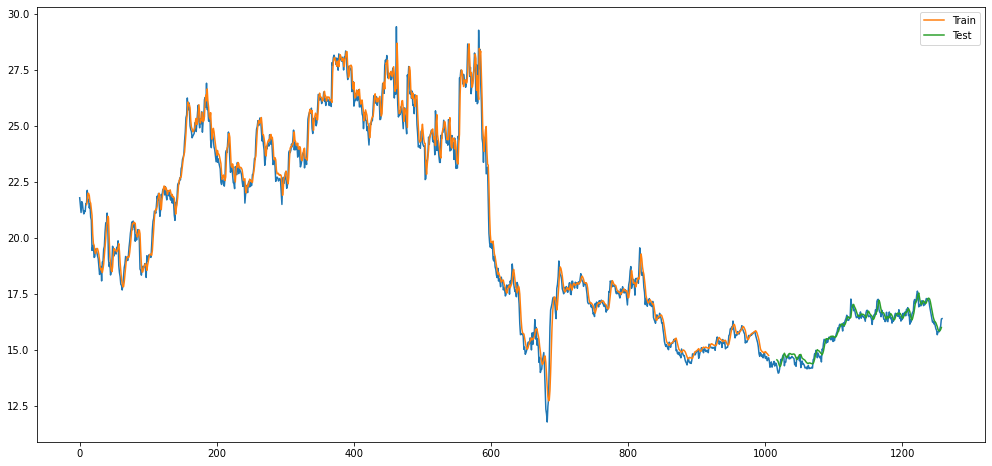

In [59]:
### Plotting 
# shift train predictions for plotting
look_back=10
plt.figure(figsize=(17,8))
trainPredictPlot = np.empty_like(df_1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(X_train_predictions_transformed)+look_back, :] = X_train_predictions_transformed
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(X_train_predictions_transformed)+(look_back*2)+1:len(df_1)-1, :] = X_test_predictions_transformed
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_1))
plt.plot(trainPredictPlot, label='Train')
plt.plot(testPredictPlot, label='Test')
plt.legend()
plt.show()

#### Now we see our model has been trained pretty well now lets do the prediction for next 10 Days

In [66]:
from keras.preprocessing.sequence import TimeseriesGenerator